# Sino-Japan trade trend

**Goal**
- Download Chinese monthly exports to and imports from Japan. [website](http://english.customs.gov.cn/statics/report/monthly.html)
- Graph the bilateral trade trend between China and Japan.

**Steps**
1. Find the .xls links per month (current year).
    - \<td\>（2）Imports and Exports by Country （Region） of Origin/Destination
2. Save the results in a dictionary SJ_year = {month: .xls link}.
3. Go to each link in the dictionary to download data in .xls format.
4. Load .xle files into Pandas DataFrame and plot time trends.



## Separate Steps

In [1]:
import requests
from scrapy import Selector # used to parse HTML
import re
import os
import pandas as pd

In [2]:
## URL with monthly url links
url = 'http://english.customs.gov.cn/statics/report/monthly.html'

## Get HTML text from website
html = requests.get(url).content

## Parse HTML
sel = Selector(text=html)

## Extract links to monthly tabs
montabs = sel.xpath('//tbody/tr[3]//a/@href').extract()

## Construct {('month', fileURL)} dict
SJ_2020 = dict()

for tab in montabs:
    # Follow URLs of each monthly tab and get HTML text
    link = requests.get(tab).content
    # Parse HTML
    selector = Selector(text=link)
    # Find link to excel file
    fileURL = selector.css('div.atcl-rct-ttl > a::attr(href)').extract()
    # Extract month
    month = [re.findall(r'\d{4}-\d\d', address)[0] for address in fileURL]
    print(month) # returns a list with 1 item
    # Store .xls address in dictionary   
    SJ_2020[month[0]] = fileURL[0] 

sorted(SJ_2020.items())  

## Download .xls files
# os.chdir('/Users/sun/Downloads')
print('Files are downloaded in: ', os.getcwd())

for month, url in SJ_2020.items():
    file = requests.get(url.replace('\\', '/'))
    with open('{}.xls'.format(month), 'wb') as f:
        f.write(file.content)
    

['2020-02']
['2020-03']
['2020-04']
['2020-05']
['2020-06']
['2020-07']
['2020-08']
['2020-09']
['2020-10']
['2020-11']
['2020-12']


In [70]:
## Load .xls files as Pandas DataFrame

df = pd.DataFrame(columns=['Country', 'Exports', 'Imports', 'month'])

for month, _ in SJ_2020.items():
    temp = pd.read_excel('{}.xls'.format(month), skiprows=3)
    temp = temp.filter(regex='Country|Exports|Imports', axis=1)
    temp.columns = ['Country', 'Exports', 'Imports']
    temp['month'] = int(month[-2:])
    df = df.append(temp, ignore_index=True)

print(df.shape)
df.head()

(2772, 4)


,Country,Exports,Imports,month
0,NaN,1 to 2,1 to 2,2
1,TOTAL,2.92449e+08,2.99544e+08,2
2,Asia:,1.45987e+08,1.61604e+08,2
3,Afghanistan,78998.4,5906.92,2
4,Bahrian,147965,27583,2


<AxesSubplot:xlabel='month', ylabel='value'>

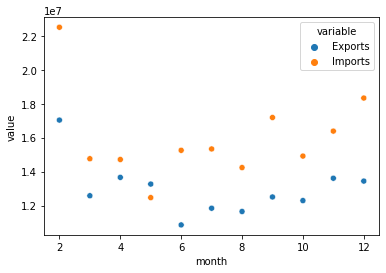

In [76]:
import seaborn as sns

japan = df[df.Country == 'Japan']

# Reshape wide to long: melt
jp = pd.melt(japan, id_vars=['Country', 'month'],
             value_vars=['Exports', 'Imports'],
             value_name='value')

# Plot Trade values (in 1000 USD) over time
sns.scatterplot(data=jp, x='month', y='value', hue='variable')


## Spider

In [ ]:
import scrapy
from scrapy.crawler import CrawlerProcess
import re

In [ ]:
class trade_Spider(scrapy.Spider):
    
    name = 'dc_chapter_spider'
    
    def start_requests(self):
        # Get HTML code from given url
        url = 'http://english.customs.gov.cn/statics/report/monthly.html'
        yield scrapy.Request(url= url, callback= self.parse_month)
             
    def parse_month(self, response):
        # Extract a list of links
        links = response.xpath('//tbody/tr[3]//a/@href').extract()
        # Follow the links to the next parser
        for url in links:
            yield response.follow(url= url, callback= self.parse_xls)
        
    def parse_xls(self, response):
        # Direct to the .xls to download
        excels = response.css('div.atcl-rct-ttl > a::attr(href)').extract()
        # Extract date from the .xls names
        months = [re.findall(r'\d{4}-\d\d', address)[0] for address in excels]
        # Store .xls address in dictionary
        for m, x in zip(months, excels):
            SJ_2020[m] = x 
        
        
SJ_2020 = dict()

process = CrawlerProcess()
process.crawl(trade_Spider)
process.start()

# Print result
sorted(SJ_2020.items())

Notes:

- To avoid `ReactorNotRestartable`, Shutdown the notebook after each `process.start()` call.
- [Speed up scrapy.](https://medium.com/better-programming/5-tips-to-build-a-faster-web-crawler-f2bbc90cf233)